In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf
import numpy as np
import os
import cv2
import tensorflow_addons as tfa

In [3]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(112,112,3),
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
base_model.trainable=True
base_model.summary()

In [5]:
model=tf.keras.Sequential([
    base_model,
    tf.keras.layers.DepthwiseConv2D(4, strides = 1, padding = 'valid', depth_multiplier = 1, use_bias = False),
    tf.keras.layers.BatchNormalization(axis = -1),
    tf.keras.layers.Conv2D(128, 1, strides = 1, padding = 'valid', use_bias = False),
    tf.keras.layers.BatchNormalization(axis = -1),
    tf.keras.layers.PReLU(shared_axes = [1, 2]),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = None, use_bias = False, kernel_initializer = 'glorot_normal'),
    tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 4, 4, 1280)        2257984   
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 1, 1, 1280)        20480     
_________________________________________________________________
batch_normalization (BatchNo (None, 1, 1, 1280)        5120      
_________________________________________________________________
conv2d (Conv2D)              (None, 1, 1, 128)         163840    
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 1, 128)         512       
_________________________________________________________________
p_re_lu (PReLU)              (None, 1, 1, 128)         128       
_________________________________________________________________
dropout (Dropout)            (None, 1, 1, 128)         0

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
        rescale=1./255,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.1)

train_generator=train_datagen.flow_from_directory(
    '../input/vggface-large/test_large',
    target_size=(112,112),
    batch_size=128,
    class_mode='sparse',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    '../input/vggface-large/test_large',
    target_size=(112,112),
    batch_size=128,
    class_mode='sparse',
    subset='validation'
    
)

Found 20409 images belonging to 65 classes.
Found 2238 images belonging to 65 classes.


In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
#model = tf.keras.Sequential([base_model,global_average_layer, dense_layer, dropout_layer, embedding_layer, normalize_layer])
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),loss=tfa.losses.TripletSemiHardLoss(margin=1.2))
lr_reduce = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=2, verbose=2, mode='auto')
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 4, 4, 1280)        2257984   
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 1, 1, 1280)        20480     
_________________________________________________________________
batch_normalization (BatchNo (None, 1, 1, 1280)        5120      
_________________________________________________________________
conv2d (Conv2D)              (None, 1, 1, 128)         163840    
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 1, 128)         512       
_________________________________________________________________
p_re_lu (PReLU)              (None, 1, 1, 128)         128       
_________________________________________________________________
dropout (Dropout)            (None, 1, 1, 128)         0

In [8]:
history=model.fit(train_generator, epochs=100, steps_per_epoch=train_generator.samples/128, 
                  validation_data=validation_generator, validation_steps=validation_generator.samples/128,
                 callbacks=[lr_reduce])

Epoch 1/100
160/159 [==============================] - 142s 889ms/step - loss: 1.1755 - val_loss: 1.1998 - lr: 0.0010
Epoch 2/100
160/159 [==============================] - 99s 619ms/step - loss: 1.1422 - val_loss: 1.1784 - lr: 0.0010
Epoch 3/100
160/159 [==============================] - 98s 615ms/step - loss: 1.1038 - val_loss: 1.1696 - lr: 0.0010
Epoch 4/100
160/159 [==============================] - 97s 609ms/step - loss: 1.0840 - val_loss: 1.1720 - lr: 0.0010
Epoch 5/100
160/159 [==============================] - 98s 613ms/step - loss: 1.0631 - val_loss: 1.1825 - lr: 0.0010
Epoch 6/100
160/159 [==============================] - 98s 611ms/step - loss: 1.0418 - val_loss: 1.1358 - lr: 0.0010
Epoch 7/100
160/159 [==============================] - 96s 600ms/step - loss: 1.0203 - val_loss: 1.1557 - lr: 0.0010
Epoch 8/100
160/159 [==============================] - 97s 606ms/step - loss: 1.0054 - val_loss: 1.1825 - lr: 0.0010
Epoch 9/100
160/159 [==============================] - 97s 607m

In [9]:
model.save('DeepMaskFacev10.h5')

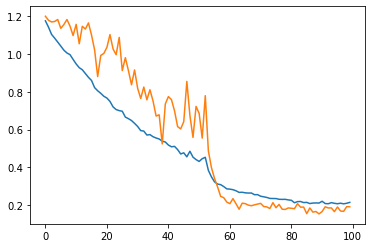

In [10]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()